## Convert Audio to image

In [1]:
import librosa.display
import librosa
import soundfile as sf
from pydub import AudioSegment


import matplotlib.pyplot as plt

import pandas as pd

import numpy as np
from IPython.display import Audio

# from tensorflow import keras

import csv
import random
import os
import shutil

Create a dataset from the urban sound 8K dataset that contains all engine idling sounds as well as an equal number of random sounds taken from the other categories. Doing so using the UrbanSound8k csv with the labels and IDs of the files


In [2]:
# create a list with all the IDs for car engine idling sounds

us_file = 'C:/Users/matthias/Documents/Projects/urban_sound_files/UrbanSound8K.csv'
# us_file = '/Users/giacomo/Documents/lavoro/sound8k_data/UrbanSound8K.csv'
list_ideng_files = []
list_of_other_sounds = []

#set a variable that can be used later. Out of the 8732 files 1000 are idling engine sounds. 
# 12.9% are the amount of files (1000) that are not idling_engine sounds The variable is needed to pick files that are non idling_engine sounds
# with a random probability of 12.9 % in order to create a balanced dataset containing idling_engine and non idling_engine sounds.  
append_probability = 12.93 # 100 / 7732 * 100
random.seed(112)


with open(us_file) as csv_file:
    reader = csv.reader(csv_file)
    
    for line in reader:
        if 'engine_idling' in line:
            list_ideng_files.append(line[0])
        else: 
            # append lines with a probability of 12.9 %
            if random.randint(0,100) <= append_probability: 
                    list_of_other_sounds.append(line[0])

print('you have ', len(list_ideng_files), 'idling engine files \n' 'and ', len(list_of_other_sounds), 'non engine sounds')

you have  1000 idling engine files 
and  1015 non engine sounds


In [4]:
    
# copy all files that are found in either one of the two lists.

sound_folder = 'C:/Users/matthias/Documents/Projects/urban_sound_files/keggel_dataset'

# create a list of all files paths from the dataset within the subfolders 

sound_files =[os.path.join(root, file) for root, directories, files in os.walk(sound_folder) for file in files]

destination_folder = 'C:/Users/matthias/Documents/Projects/urban_sound_files/our_dataset'


In [ ]:

# Now copy all files present in the two lists into a new folder (destination folder var)
for path in sound_files:
    filename = os.path.basename(path)
    if filename in (list_ideng_files + list_of_other_sounds):
        destination = os.path.join(destination_folder, filename)
        shutil.copy2(path, destination_folder)

In [33]:
len(sound_files)

1976

## Standardize imput 


Some files are recorded with one, some with two channels. Lets convert all files to two channels.
Also, some have a sampling rate of 48.000 Hz, some of 44.100 Hz. Here we need to make all imput arrays the same size.
Last we make all files the same length by adding silence to shorter files

In [5]:


# get full path of the audio files
full_file_paths = [os.path.join(destination_folder, filename) 
                   for filename in os.listdir(destination_folder) 
                   if os.path.isfile(os.path.join(destination_folder, filename))] 


def standardize_audio(audio, target_length):
    # apply sampling rate of 44100 and mono to all files
    librosa.load(audio, sr=44100, mono = True) 
    
    # Add silence to shorter files
    current_audio = AudioSegment.from_wav(audio)
    current_length = len(current_audio)
    
    if current_length < target_length: 
        # get difference in duration and calculate the sound of silence
        silence_duration = target_length - current_length
        # create a sound of silence with the needed length   
        silence = AudioSegment.silent(duration=silence_duration)
        #add the sound of silence at the end of the file
        padded_audio = current_audio + silence
        return padded_audio
    else:
        return current_audio
        
# find max duration in ms within all audio files        
target_length = max([(librosa.get_duration(path=file)) for file in full_file_paths]) * 1000 

# loop trough all files and apply the standardization
# To save some space on the disc we overwrite the files instead of creating new ones!
for file in full_file_paths:
    padded_audio = standardize_audio(file, target_length) 
    padded_audio.export(file.replace(".wav", "_adjusted.wav"), format="wav")



## Create mel spectrograms

First we check one of the samples just to make sure everything is right. We take a look at a waveplot as well as a mel spectrogram.
After that we will create mel spectrograms for each audio file.

In [53]:
# select an audio file as an example
audio_file =  'C:/Users/matthias/Documents/Projects/urban_sound_files/our_dataset_conv/344-3-5-0.wav'


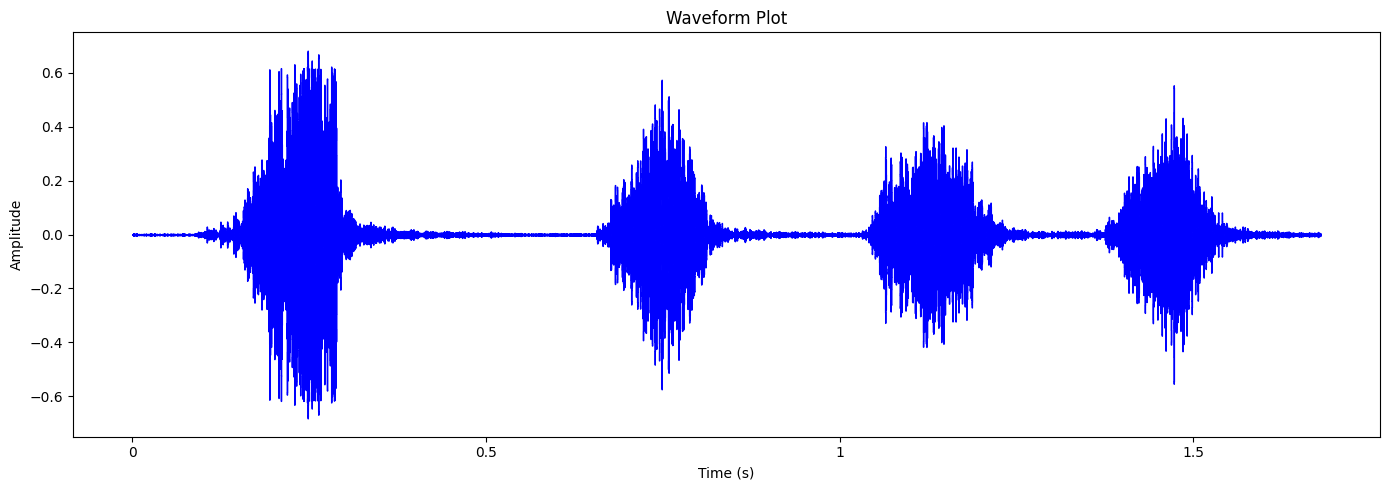

In [5]:
#If samples are not already, convert to np.array, can probably be simpflified, no need for if check

y, sr = librosa.load(audio_file, sr=44100, mono = True)
if not isinstance(y, np.ndarray):
    samples = np.array(y)


plt.figure(figsize=(14, 5))
librosa.display.waveshow(y, sr=sr, color='b') #color specification needed due to version incompatibility problems btw librosa and matplotlib
plt.title('Waveform Plot')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.tight_layout()
plt.show()

In [6]:
# Listen to the audio 
Audio(audio_file)


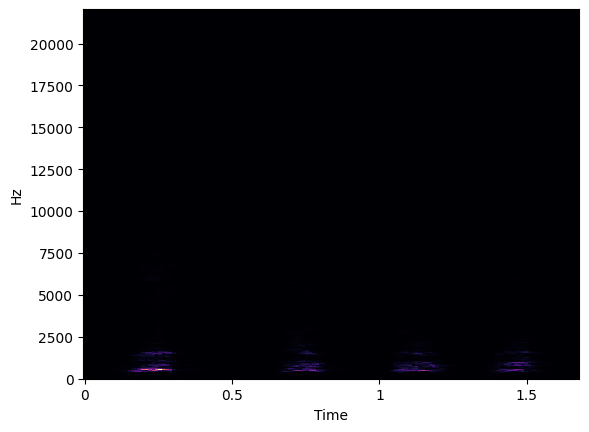

In [7]:
#Apply fourier transformation and plot 

sgram = librosa.stft(y)
librosa.display.specshow(np.abs(sgram), sr=sr, x_axis='time', y_axis='linear')

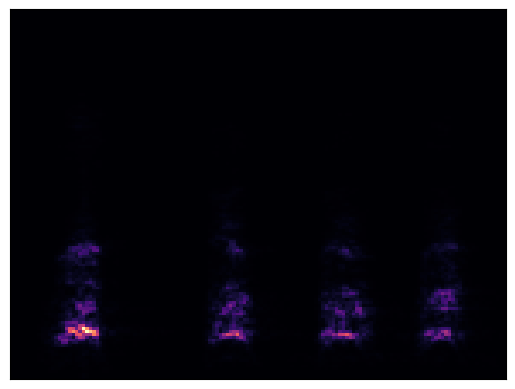

In [8]:
# Create a mel spectrogramm 
sgram_mag, _ = librosa.magphase(sgram)
mel_scale_sgram = librosa.feature.melspectrogram(S=sgram_mag, sr=sr)
librosa.display.specshow(mel_scale_sgram)


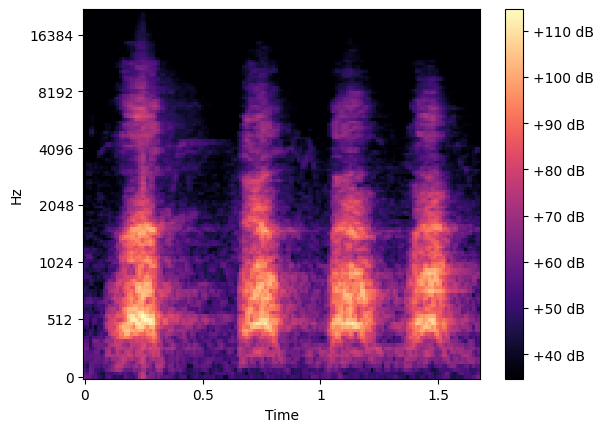

In [9]:

mel_sgram = librosa.amplitude_to_db(mel_scale_sgram, ref=np.min)
librosa.display.specshow(mel_sgram, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')

In [10]:
def create_mel_specs (path_to_wav, path_to_png):

    #create a list of all wav files needed to be converted: 
    
    file_list = [file for file in os.listdir(path_to_wav)]
    #print(file_list)
    
    for file in file_list:    
        
        #create correct file name for saving
        audio_file = os.path.join(path_to_wav, file)
        output_file = os.path.join(path_to_png, os.path.splitext(file)[0] + '.png')
        
        # load the files and transfrom into np array
        samples, sample_rate = librosa.load(audio_file, sr=44100)
        if not isinstance(samples, np.ndarray):
            samples = np.array(samples)
        
        #apply a stft transformation    
        stft = librosa.stft(samples)

        #modify it in order to use the mel-scale instead of frenquency
        mel_scale_spec, par = librosa.magphase(stft)
        mel_spec = librosa.feature.melspectrogram(S=mel_scale_spec, sr=sample_rate)

        # Go from amplitude to db 
        mel_spec_db = librosa.amplitude_to_db(mel_spec, ref=np.min)

        # create and save the figure
        #plt.figure()        
        #librosa.display.specshow(mel_spec_db, x_axis='time', y_axis='mel', sr=sample_rate, fmax=8000)
        #plt.axis('off')

        #save plot without any white border
        plt.savefig(output_file, bbox_inches='tight', pad_inches=0, transparent=True)
                

In [11]:
#Test section for the function

# here one might need to activate in order to save the images
## matplotlib.use('Agg')
# This can become a problem later on when trying to show plots in the notebook. Fixed it by restarting the kernel

path_to_wav = '/Users/giacomo/Documents/lavoro/sound8k_data/our_dataset/'
path_to_png = '/Users/giacomo/Documents/lavoro/sound8k_data/mel_specs/'
test = create_mel_specs(path_to_wav, path_to_png)

['44737-5-0-2.wav', '133494-2-0-26.wav', '209992-5-2-81.wav', '145206-6-4-0.wav', '94632-5-0-0.wav', '155217-9-1-24.wav', '17853-5-0-11.wav', '201988-5-0-8.wav', '195451-5-0-4.wav', '159726-3-0-0.wav', '146845-0-0-21.wav', '159742-8-0-12.wav', '201988-5-0-21.wav', '155127-9-0-2.wav', '74726-8-2-1.wav', '128160-5-0-15.wav', '209992-5-2-42.wav', '65381-3-0-7.wav', '180937-7-2-6.wav', '54823-3-0-0.wav', '34771-3-0-5.wav', '147926-0-0-44.wav', '39856-5-0-28.wav', '72259-1-10-0.wav', '195451-5-0-11.wav', '39856-5-0-14.wav', '61503-2-0-5.wav', '113202-5-0-0.wav', '176787-5-0-9.wav', '113203-5-3-1.wav', '50618-6-0-0.wav', '156358-5-0-2.wav', '71529-4-1-3.wav', '81068-5-0-1.wav', '113205-5-1-4.wav', '201652-5-4-9.wav', '113216-5-0-0.wav', '107228-5-0-3.wav', '106015-5-0-0.wav', '16692-5-0-7.wav', '62566-5-1-1.wav', '194321-9-0-61.wav', '17853-5-0-3.wav', '177729-0-0-28.wav', '39884-5-0-0.wav', '165775-7-1-0.wav', '137156-9-0-73.wav', '144007-5-0-9.wav', '128607-4-0-4.wav', '182739-2-0-24.wav',

<Figure size 640x480 with 0 Axes>

In [12]:
# actual application of the function:

""" path_to_wav = 'C:/Users/matthias/Documents/Projects/urban_sound_files/our_dataset/'
path_to_png = 'C:/Users/matthias/Documents/Projects/urban_sound_files/mel_specs/'
test = create_mel_specs(path_to_wav, path_to_png) """

" path_to_wav = 'C:/Users/matthias/Documents/Projects/urban_sound_files/our_dataset/'\npath_to_png = 'C:/Users/matthias/Documents/Projects/urban_sound_files/mel_specs/'\ntest = create_mel_specs(path_to_wav, path_to_png) "

## Create NNs

## import metadata 

import the UrbanSound8k csv, filter out all entries that are not used in this project and take a look at the data.


In [13]:
df = pd.read_csv(us_file, header=0)
print(df.head(5))

      slice_file_name    fsID  start        end  salience  fold  classID  \
0    100032-3-0-0.wav  100032    0.0   0.317551         1     5        3   
1  100263-2-0-117.wav  100263   58.5  62.500000         1     5        2   
2  100263-2-0-121.wav  100263   60.5  64.500000         1     5        2   
3  100263-2-0-126.wav  100263   63.0  67.000000         1     5        2   
4  100263-2-0-137.wav  100263   68.5  72.500000         1     5        2   

              class  
0          dog_bark  
1  children_playing  
2  children_playing  
3  children_playing  
4  children_playing  


In [14]:
# get rid of all unused files

filtered_df = df[df['slice_file_name'].isin(list_ideng_files + list_of_other_sounds)]
    
print(filtered_df.head(10))

      slice_file_name    fsID  start   end  salience  fold  classID  \
8   100263-2-0-36.wav  100263   18.0  22.0         1     5        2   
14   100652-3-0-0.wav  100652    0.0   4.0         1     2        3   
17   100652-3-0-3.wav  100652    1.5   5.5         1     2        3   
22   100852-0-0-0.wav  100852    0.0   4.0         1     5        0   
28  100852-0-0-14.wav  100852    7.0  11.0         1     5        0   
29  100852-0-0-15.wav  100852    7.5  11.5         1     5        0   
36  100852-0-0-21.wav  100852   10.5  14.5         1     5        0   
74  101729-0-0-18.wav  101729    9.0  13.0         2     9        0   
79  101729-0-0-24.wav  101729   12.0  16.0         2     9        0   
81  101729-0-0-28.wav  101729   14.0  18.0         2     9        0   

               class  
8   children_playing  
14          dog_bark  
17          dog_bark  
22   air_conditioner  
28   air_conditioner  
29   air_conditioner  
36   air_conditioner  
74   air_conditioner  
79   air_co

In [15]:
# As we are only interested in idling engine sounds and use the other files as a non engine control to train our network, 
# we now change the label of everything that is non idling engine sound to that.

filtered_df.loc[filtered_df['class'] != 'engine_idling', 'class'] = 'non_idling_engine'
print(filtered_df.head(100))

       slice_file_name    fsID  start   end  salience  fold  classID  \
8    100263-2-0-36.wav  100263   18.0  22.0         1     5        2   
14    100652-3-0-0.wav  100652    0.0   4.0         1     2        3   
17    100652-3-0-3.wav  100652    1.5   5.5         1     2        3   
22    100852-0-0-0.wav  100852    0.0   4.0         1     5        0   
28   100852-0-0-14.wav  100852    7.0  11.0         1     5        0   
..                 ...     ...    ...   ...       ...   ...      ...   
250   103258-5-0-3.wav  103258    1.5   5.5         1     1        5   
251   103258-5-0-4.wav  103258    2.0   6.0         1     1        5   
252   103258-5-0-5.wav  103258    2.5   6.5         1     1        5   
253   103258-5-0-6.wav  103258    3.0   7.0         1     1        5   
254   103258-5-0-7.wav  103258    3.5   7.5         1     1        5   

                 class  
8    non_idling_engine  
14   non_idling_engine  
17   non_idling_engine  
22   non_idling_engine  
28   non_i

In [16]:
from tensorflow import keras

# Preprocess and batch the dataset (add any necessary preprocessing here)
data_df = filtered_df[['slice_file_name', 'class']]
data_df.loc[:,'slice_file_name'] = data_df['slice_file_name'].str.replace('.wav', '.png')
dataset_path = '/Users/giacomo/Documents/lavoro/sound8k_data/mel_specs/' #where the mel specs are
# Create an ImageDataGenerator for data loading and preprocessing
datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0/255,  # Normalize pixel values to the range [0, 1]
    validation_split=0.2  # Split the data into training and validation sets
)

# Use flow_from_dataframe to load and preprocess the images
batch_size = 12  # Adjust this according to your needs
train_generator = datagen.flow_from_dataframe(
    data_df,
    directory=dataset_path,
    x_col="slice_file_name",  # Column containing filenames
    y_col="class",  # Column containing class labels
    target_size=(224, 224),  # Reshape your images to a desired size
    batch_size=batch_size,
    class_mode='categorical',  # If you have multiple classes
    subset='training', 
    validate_filenames=False  # For the training set
)

validation_generator = datagen.flow_from_dataframe(
    data_df,
    directory=dataset_path,
    x_col="slice_file_name",
    y_col="class",
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation', 
    validate_filenames=False # For the validation set
)

num_classes = len(train_generator.class_indices)  # Get the number of classes

Found 1612 non-validated image filenames belonging to 2 classes.
Found 403 non-validated image filenames belonging to 2 classes.


In [28]:
len(df)

8732

In [24]:
# Get the sets of filenames
validation_filenames = set(validation_generator.filenames)
train_filenames = set(train_generator.filenames)

# Find common filenames
common_filenames = validation_filenames & train_filenames

# Check if there are any common filenames
if common_filenames:
    print("Common files in validation and train generators:", common_filenames)
else:
    print("No common files in validation and train generators.")

No common files in validation and train generators.


In [25]:
# Get the sets of filenames
validation_filenames = set(validation_generator.filenames)
train_filenames = set(train_generator.filenames)

# Print the number of unique files in each generator
print("Number of unique files in validation generator:", len(validation_filenames))
print("Number of unique files in train generator:", len(train_filenames))

# Print the total number of unique files in both generators
print("Total number of unique files in both generators:", len(validation_filenames | train_filenames))

Number of unique files in validation generator: 403
Number of unique files in train generator: 1612
Total number of unique files in both generators: 2015


In [23]:
a = set ("a", "b", "c")
b = set ("a", "d", "c")

# Check if the sets are equal
are_equal = a == b

print("Are the validation and train generators containing the same files?", are_equal)

TypeError: set expected at most 1 argument, got 3

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define the model
model = Sequential()

# Add layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))  # Assuming you have 2 classes

#set the callback for tensorboard. This put all the model data into a log file that can be used to visualize the training process
tb_callback = tf.keras.callbacks.TensorBoard(log_dir='logs/', histogram_freq=1)

# Compile the model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

# Summary of the model
model.summary()

In [ ]:
# launch tensorboard
%load_ext tensorboard
%tensorboard --logdir logs/fit
